In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(5)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://10.148.1.6:58704 Dashboard: http://10.148.1.6:54349/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB


In [7]:
v = 'Eta'

face = 5

## open files, nc files
ncdata_dir = scratch+'/mit_nc_new/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc_new/


In [8]:
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:1]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 2
Number of files processed: 1
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 5
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [9]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
print(ds)

CPU times: user 20 ms, sys: 16 ms, total: 36 ms
Wall time: 77.8 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 1440)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 5
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>


In [25]:
ds1 = ds.isel(time=slice(0,720))
ds1 = xr.merge([ds1,grid])
chunks1={'time': len(ds1['time'])}
%time ds1 = ds1.chunk(chunks1)

print(ds1)
print('\n data size: %.1f GB' %(ds1.nbytes / 1e9))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.75 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 720)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 5
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=

In [26]:
%time Eta1 = ds1['Eta'].persist()

CPU times: user 920 ms, sys: 8 ms, total: 928 ms
Wall time: 924 ms


In [27]:
Eta1.time.size

720

In [28]:
eta_fft = xrft.dft(Eta1.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_eta1 = (eta_fft*eta_fft.conj()).where(eta_fft!=0., drop=False).mean(dim=('i','j'))
E_eta1 = E_eta1.astype('f8').rename('Eta_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [29]:
%time E_eta1.load()

CPU times: user 1min 34s, sys: 5.02 s, total: 1min 39s
Wall time: 3min 43s


<xarray.DataArray 'Eta_power_spectrum ()' (freq_time: 720)>
array([1.619030e-08, 2.053487e+02, 1.640241e+02, ..., 9.712294e+01,
       1.640241e+02, 2.053487e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 3.858e-07 7.716e-07 1.157e-06 ...
    freq_time_spacing  float64 3.858e-07

No handles with labels found to put in legend.


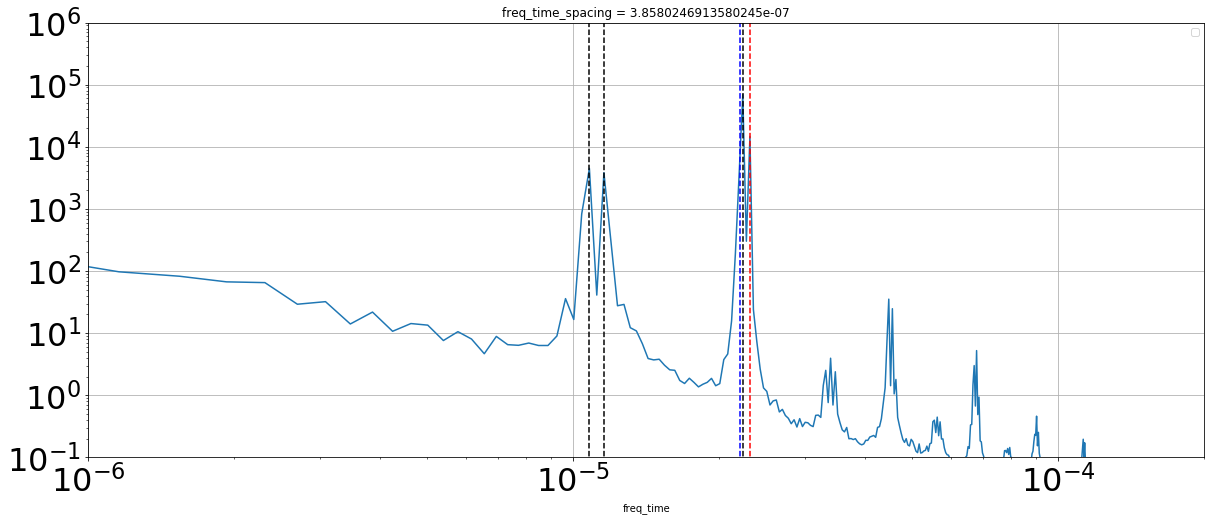

In [30]:

fig, ax = plt.subplots(figsize=(20,8))
E_eta1.where(E_eta1.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-6,2*1e-4])
ax.set_ylim([1e-1,1e6])

# M2 #
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') 
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--') 
ax.plot([1/12.58/3600,1/12.58/3600],[1e-2,1e6],'b--') 

# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--')

ax.tick_params(labelsize=32)



In [17]:
ds2 = ds.isel(time=slice(0,1000))
ds2 = xr.merge([ds2,grid])
chunks2={'time': len(ds2['time'])}
%time ds2 = ds2.chunk(chunks2)

print(ds2)
print('\n data size: %.1f GB' %(ds2.nbytes / 1e9))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.55 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 1000)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 5
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize

In [18]:
%time Eta2 = ds2['Eta'].persist()

CPU times: user 848 ms, sys: 4 ms, total: 852 ms
Wall time: 848 ms


In [19]:
eta_fft = xrft.dft(Eta2.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_eta2 = (eta_fft*eta_fft.conj()).where(eta_fft!=0., drop=False).mean(dim=('i','j'))
E_eta2 = E_eta2.astype('f8').rename('Eta_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [20]:
%time E_eta2.load()

CPU times: user 1min 32s, sys: 4.83 s, total: 1min 37s
Wall time: 4min 1s


<xarray.DataArray 'Eta_power_spectrum ()' (freq_time: 1000)>
array([1.963154e-08, 5.170235e+02, 2.547082e+02, ..., 3.055562e+02,
       2.547082e+02, 5.170235e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 2.778e-07 5.556e-07 8.333e-07 ...
    freq_time_spacing  float64 2.778e-07

No handles with labels found to put in legend.
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


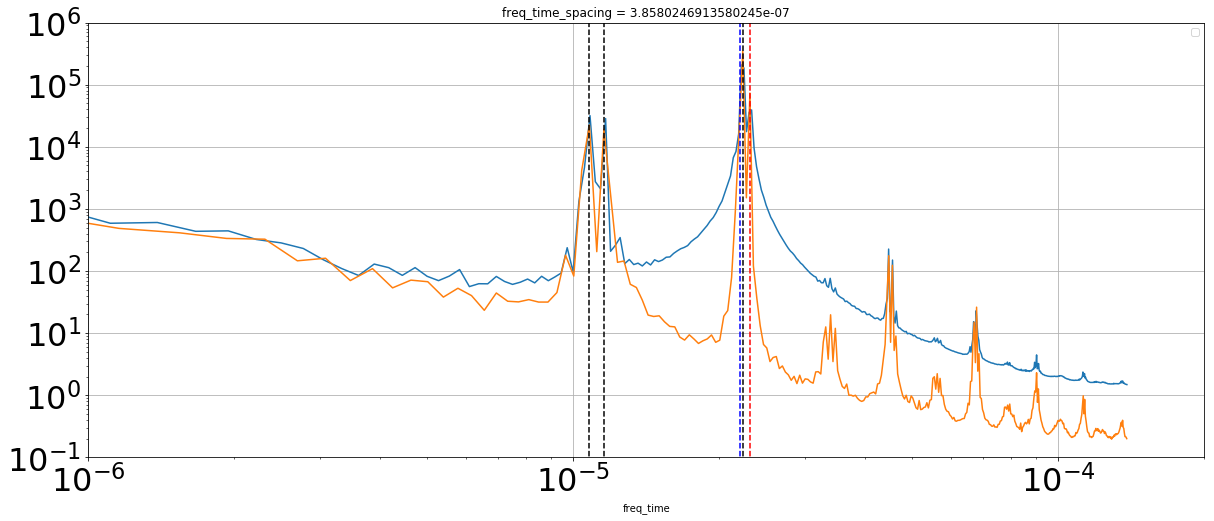

In [31]:
E1 = E_eta1/720*3600
E2 = E_eta2/1000*3600



fig, ax = plt.subplots(figsize=(20,8))
E2.where(E_eta2.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
E1.where(E_eta1.freq_time>0).plot(ax=ax)


ax.set_xlim([1e-6,2*1e-4])
ax.set_ylim([1e-1,1e6])

# M2 #
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') 
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--') 
ax.plot([1/12.58/3600,1/12.58/3600],[1e-2,1e6],'b--') 

# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--')

ax.tick_params(labelsize=32)



In [32]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None


Client Scheduler: tcp://10.148.1.6:58704 Dashboard: http://10.148.1.6:54349/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB
